#A MACHINE LEARNING-BASED APPROACH TO CLASSIFY STUDENTS FOR RECRUITMENT (CUSTOM ENSEMBLE LEARNING) (#3)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.combine import SMOTETomek
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Load Data

In [ ]:
df = pd.read_excel("sample_data/Data Placement.xlsx")
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN


#Rename Columns

In [ ]:
#rename columns
df.rename(columns=df.iloc[0], inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN


In [ ]:
#drop 0th index
df.drop(index=0, inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
5,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


In [ ]:
#reset index
df.reset_index(inplace=True)
df.head()

,index,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
2,3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
3,4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
4,5,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


In [ ]:
#drop 'index' column
df.drop(columns='index', inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


#NaN in Placement Status -> Not Placed

In [ ]:
df['Placement Status'] = df['Placement Status'].fillna('Not Placed')
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,Not Placed
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,Not Placed
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,Not Placed
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,Not Placed


#Setting Target in 0/1 Format
##0 -> Positive (or Placed)
##1 -> Negative (or Not Placed)

In [ ]:
df['Placement Status'].replace("Placed", 0, inplace=True)
df['Placement Status'].replace("Not Placed", 1, inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,0
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,1
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,1
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,1
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12864 entries, 0 to 12863
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Branch                12864 non-null  object
 1   Degree                12864 non-null  object
 2   Aptitude              12864 non-null  object
 3   English               12864 non-null  object
 4   Quantitative          12864 non-null  object
 5   Analytical            12864 non-null  object
 6   Domain                12864 non-null  object
 7   Computer Fundamental  12864 non-null  object
 8   Coding                12864 non-null  object
 9   Placement Status      12864 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 1005.1+ KB


#Data Type Conversion

In [ ]:
df['Aptitude'] = (pd.to_numeric(df['Aptitude'], errors='coerce', downcast='float')).astype('float64')
df['English'] = (pd.to_numeric(df['English'], errors='coerce', downcast='float')).astype('float64')
df['Quantitative'] = (pd.to_numeric(df['Quantitative'], errors='coerce', downcast='float')).astype('float64')
df['Analytical'] = (pd.to_numeric(df['Analytical'], errors='coerce', downcast='float')).astype('float64')
df['Domain'] = (pd.to_numeric(df['Domain'], errors='coerce', downcast='float')).astype('float64')
df['Computer Fundamental'] = (pd.to_numeric(df['Computer Fundamental'], errors='coerce', downcast='float')).astype('float64')
df['Coding'] = (pd.to_numeric(df['Coding'], errors='coerce', downcast='float')).astype('float64')
df.dtypes

Branch                   object
Degree                   object
Aptitude                float64
English                 float64
Quantitative            float64
Analytical              float64
Domain                  float64
Computer Fundamental    float64
Coding                  float64
Placement Status          int64
dtype: object

#Missing Values Treatment

##Finding missing value locations

In [ ]:
df.isnull().sum()

Branch                  0
Degree                  0
Aptitude                1
English                 0
Quantitative            0
Analytical              0
Domain                  0
Computer Fundamental    0
Coding                  0
Placement Status        0
dtype: int64

##Handling missing values

In [ ]:
#imputing mode (based on Placement Status)
def impute_nan(d, variable):
  #Placement Status = 0
  idx_0 = d[d['Placement Status'] == 0].index.tolist() #indexes
  var_0 = d.loc[idx_0, variable] #feature
  var_0_mode = var_0.mode()[0] #mode
  
  #Placement Status = 1
  idx_1 = d[d['Placement Status'] == 1].index.tolist()  #indexes  
  var_1 = d.loc[idx_1, variable] #feature 
  var_1_mode = var_1.mode()[0] #mode

  #NaNs    
  idx_nan = d[d[variable].isnull()].index.tolist() #indexes
  for i in range(len(idx_nan)):
    if d.loc[idx_nan[i], 'Placement Status'] == 0:
      d.loc[idx_nan[i], variable] = var_0_mode
    else:
      d.loc[idx_nan[i], variable] = var_1_mode
  
  return d

In [ ]:
#df.dropna(inplace=True)
df = impute_nan(df, 'Aptitude')
df.isnull().sum()

Branch                  0
Degree                  0
Aptitude                0
English                 0
Quantitative            0
Analytical              0
Domain                  0
Computer Fundamental    0
Coding                  0
Placement Status        0
dtype: int64

#Drop Unwanted Columns

##In this case Branch	& Degree, as Branch	& Degree doesn't play important role in Campus Placement.

In [ ]:
df2 = df.drop(columns=['Branch',	'Degree'])
df2.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0,0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0,1
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0,1
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0,1
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0,1


#Count (Positive class and Negative class)

In [ ]:
unique_class, counts_class = np.unique(df['Placement Status'], return_counts=True)
dict(zip(unique_class, counts_class))

{0: 767, 1: 12097}

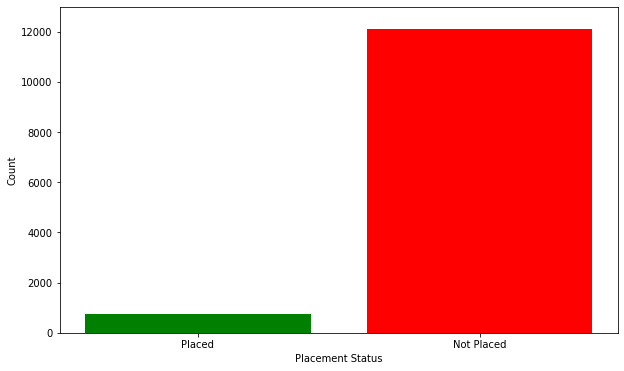

In [ ]:
cY = counts_class.tolist()
cls = unique_class.tolist()
cls_label = []
for c in cls:
  if c == 0:
    cls_label.append('Placed')
  else:
    cls_label.append('Not Placed')

plt.figure(figsize=(10,6))
plt.bar(cls_label, cY, color=['Green', 'Red'])
plt.xlabel("Placement Status")
plt.ylabel('Count')
plt.ylim(0, 13000)
plt.show()

##*Imbalanced data*

#Handling Imbalanced Data - *Over Sampling*

##Separating Features & Labels

In [ ]:
x = df2.drop(columns='Placement Status')
x.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0


In [ ]:
y = df2['Placement Status']
y.head()

0    0
1    1
2    1
3    1
4    1
Name: Placement Status, dtype: int64

##Oversampling

In [ ]:
smk = SMOTETomek(ratio=1)
x_res, y_res = smk.fit_sample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
unique_y_res, counts_y_res = np.unique(y_res, return_counts=True)
dict(zip(unique_y_res, counts_y_res))

{0: 12096, 1: 12096}

#Count (Positive class and Negative class)

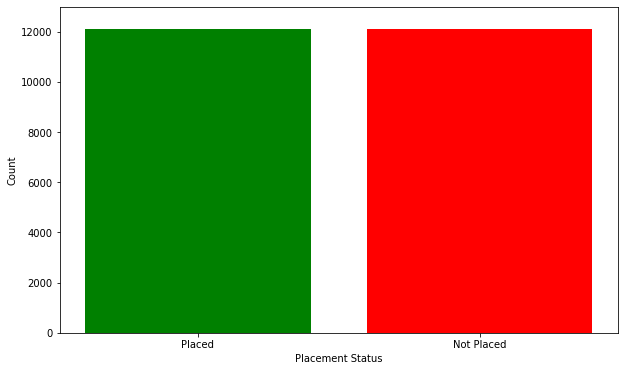

In [ ]:
cY = counts_y_res.tolist()
cls = unique_y_res.tolist()
cls_label = []
for c in cls:
  if c == 0:
    cls_label.append('Placed')
  else:
    cls_label.append('Not Placed')

plt.figure(figsize=(10,6))
plt.bar(cls_label, cY, color=['Green', 'Red'])
plt.xlabel("Placement Status")
plt.ylabel('Count')
plt.ylim(0, 13000)
plt.show()

##*Balanced data*

#Final Features & Labels

In [ ]:
features = pd.DataFrame(x_res, columns=x.columns)
features.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0


In [ ]:
labels = pd.Series(y_res, name=y.name)
labels.head()

0    0
1    1
2    1
3    1
4    1
Name: Placement Status, dtype: int64

#Train-Test Split

In [ ]:
features_trainval, features_test, labels_trainval, labels_test = train_test_split(features, labels, test_size=0.3, random_state=0)

#Data Pre-processing

In [ ]:
#training-validation data
scaler = MinMaxScaler()
X_trainval = scaler.fit_transform(features_trainval)  #(X - Xmin)/(Xmax - Xmin)
df_X_trainval = pd.DataFrame(data=X_trainval, columns=features.columns)
df_X_trainval.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,0.687923,0.624054,0.472145,0.668570,0.352941,0.509988,0.0
1,0.606580,0.634068,0.397635,0.528581,0.472257,0.354839,0.0
2,0.523810,0.494737,0.400000,0.470000,0.235294,0.354839,0.0
3,0.714286,0.631579,0.530000,0.670000,0.235294,0.354839,0.2
4,0.583333,0.631579,0.530000,0.330000,0.588235,0.215054,0.0


In [ ]:
#testing data
X_test = scaler.transform(features_test)
df_X_test = pd.DataFrame(data=X_test, columns=features.columns)
df_X_test.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,0.476190,0.347368,0.400000,0.470000,0.588235,0.139785,0.200000
1,0.357143,0.368421,0.200000,0.350000,0.270588,0.290323,0.000000
2,0.569310,0.631579,0.294660,0.530000,0.269941,0.139785,0.000000
3,0.761905,0.768421,0.670000,0.530000,0.176471,0.215054,0.200000
4,0.690476,0.705263,0.346443,0.715906,0.660876,0.784946,0.981208


In [ ]:
#training-validation data count
Y_trainval = labels_trainval
unique_Y_trainval, counts_Y_trainval = np.unique(Y_trainval, return_counts=True)
dict(zip(unique_Y_trainval, counts_Y_trainval))

{0: 8473, 1: 8461}

In [ ]:
#testing data count
Y_test = labels_test
unique_Y_test, counts_Y_test = np.unique(Y_test, return_counts=True)
dict_Y_test = dict(zip(unique_Y_test, counts_Y_test))
dict_Y_test

{0: 3623, 1: 3635}

#Building models

##Base Model

In [ ]:
bm = list()

knn = Pipeline([('clf_knn', KNeighborsClassifier(n_neighbors=3))])
bm.append(('knn', knn))

rf = Pipeline([('clf_rf', RandomForestClassifier(n_estimators=90))])
bm.append(('rf', rf))

###Model-1
###(Voting Ensemble)

In [ ]:
clf_em1 = VotingClassifier(estimators=bm, voting='soft')

###Model-2
###(Stacking Ensemble)

In [ ]:
mm = LogisticRegression() #meta model
clf_em2 = StackingClassifier(estimators=bm, final_estimator=mm)

#StratifiedKFold Cross Validation

In [ ]:
X = np.array(X_trainval)
Y = np.array(Y_trainval)

#training score
train_score_em1 = []
train_score_em2 = []
#training time
train_time_em1 = []
train_time_em2 = []
#validation accuracy
val_accuracy_em1 = []
val_accuracy_em2 = []

skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, Y)

for train_index, val_index in skf.split(X, Y):  
  X1_train, X1_val = X[train_index], X[val_index]
  Y1_train, Y1_val = Y[train_index], Y[val_index]
   
  #training
  #Model-1    
  st_train_em1 = time.time()  #start time
  clf_em1.fit(X1_train, Y1_train)  
  et_train_em1 = time.time()  #end time
  train_score_em1.append(clf_em1.score(X1_train, Y1_train))
  train_time_em1.append(et_train_em1 - st_train_em1)
  #Model-2    
  st_train_em2 = time.time()  #start time
  clf_em2.fit(X1_train, Y1_train)  
  et_train_em2 = time.time()  #end time
  train_score_em2.append(clf_em2.score(X1_train, Y1_train))
  train_time_em2.append(et_train_em2 - st_train_em2)

  #validation
  #Model-1  
  prediction_em1 = clf_em1.predict(X1_val)      
  val_accuracy_em1.append(accuracy_score(Y1_val, prediction_em1))
  #Model-2  
  prediction_em2 = clf_em2.predict(X1_val)      
  val_accuracy_em2.append(accuracy_score(Y1_val, prediction_em2))

#training score  
train_score_em1 = np.array(train_score_em1)
train_score_em2 = np.array(train_score_em2)
#training time
train_time_em1 = np.array(train_time_em1)
train_time_em2 = np.array(train_time_em2)
#validation accuracy
val_accuracy_em1 = np.array(val_accuracy_em1)
val_accuracy_em2 = np.array(val_accuracy_em2)

In [ ]:
#Model-1
train_score_em1.mean(), train_time_em1.mean(), val_accuracy_em1.mean()

(0.9988779873376926, 1.1379627386728923, 0.9703555115580333)

In [ ]:
#Model-2
train_score_em2.mean(), train_time_em2.mean(), val_accuracy_em2.mean()

(0.9992913612497049, 5.9058778285980225, 0.9916735874880755)

#Testing Phase

In [ ]:
#Model-1
Y_pred_em1 = clf_em1.predict(X_test)
test_score_em1 = accuracy_score(Y_test, Y_pred_em1)
test_score_em1

0.9709286304767153

In [ ]:
#Model-2
Y_pred_em2 = clf_em2.predict(X_test)
test_score_em2 = accuracy_score(Y_test, Y_pred_em2)
test_score_em2

0.9900799118214384

#Confusion Matrix

In [ ]:
#Model-1
conf_mat_em1 = confusion_matrix(Y_test, Y_pred_em1)
conf_mat_em1

array([[3613,   10],
       [ 201, 3434]])

In [ ]:
#Model-2
conf_mat_em2 = confusion_matrix(Y_test, Y_pred_em2)
conf_mat_em2

array([[3593,   30],
       [  42, 3593]])

#Classification Report

In [ ]:
#Model-1
classification_report_em1 = classification_report(Y_test, Y_pred_em1, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_em1 = pd.DataFrame(classification_report_em1).transpose()
df_classification_report_em1

,precision,recall,f1-score,support
Placed,0.947299,0.997240,0.971628,3623.000000
Not Placed,0.997096,0.944704,0.970194,3635.000000
accuracy,0.970929,0.970929,0.970929,0.970929
macro avg,0.972198,0.970972,0.970911,7258.000000
weighted avg,0.972239,0.970929,0.970910,7258.000000


In [ ]:
#Model-2
classification_report_em2 = classification_report(Y_test, Y_pred_em2, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_em2 = pd.DataFrame(classification_report_em2).transpose()
df_classification_report_em2

,precision,recall,f1-score,support
Placed,0.988446,0.991720,0.99008,3623.00000
Not Placed,0.991720,0.988446,0.99008,3635.00000
accuracy,0.990080,0.990080,0.99008,0.99008
macro avg,0.990083,0.990083,0.99008,7258.00000
weighted avg,0.990085,0.990080,0.99008,7258.00000


#Testing with Outside Data

In [ ]:
outside_data = np.array([58, 71, 42,	50,	59,	51, 95])
outside_data = scaler.transform(outside_data.reshape(1, -1)) #data pre-processing

In [ ]:
#Model-1
clf_em1.predict(outside_data)

array([0])

In [ ]:
#Model-2
clf_em2.predict(outside_data)

array([0])

#Model Comparison 
##(Model-1, Model-2)

In [ ]:
model = ['EM1', 'EM2']

##wrt TP, FN, FP, and TN

In [ ]:
tp_fn_fp_tn = np.array([        
                        [conf_mat_em1[0][0], conf_mat_em1[0][1], conf_mat_em1[0][0]+conf_mat_em1[0][1], conf_mat_em1[1][0], conf_mat_em1[1][1], conf_mat_em1[1][0]+conf_mat_em1[1][1]],
                        [conf_mat_em2[0][0], conf_mat_em2[0][1], conf_mat_em2[0][0]+conf_mat_em2[0][1], conf_mat_em2[1][0], conf_mat_em2[1][1], conf_mat_em2[1][0]+conf_mat_em2[1][1]]
                        ])
model_tp_fn_fp_tn = pd.DataFrame(data=tp_fn_fp_tn, columns=['TP', 'FN', 'P (Placed)', 'FP', 'TN', 'N (Not Placed)'], index=model)
model_tp_fn_fp_tn

,TP,FN,P (Placed),FP,TN,N (Not Placed)
EM1,3613,10,3623,201,3434,3635
EM2,3593,30,3623,42,3593,3635


##wrt Precision, Recall, and F1-Score

In [ ]:
precision_recall_f1_score = np.array([
                                      [df_classification_report_em1.loc['Placed', 'precision'], df_classification_report_em1.loc['Not Placed', 'precision'], df_classification_report_em1.loc['Placed', 'recall'], df_classification_report_em1.loc['Not Placed', 'recall'], df_classification_report_em1.loc['Placed', 'f1-score'], df_classification_report_em1.loc['Not Placed', 'f1-score']],
                                      [df_classification_report_em2.loc['Placed', 'precision'], df_classification_report_em2.loc['Not Placed', 'precision'], df_classification_report_em2.loc['Placed', 'recall'], df_classification_report_em2.loc['Not Placed', 'recall'], df_classification_report_em2.loc['Placed', 'f1-score'], df_classification_report_em2.loc['Not Placed', 'f1-score']]
                                      ])
model_precision_recall_f1_score = pd.DataFrame(data=precision_recall_f1_score, columns=['Precision (Placed)', 'Precision (Not Placed)', 'Recall (Placed)', 'Recall (Not Placed)', 'F1-Score (Placed)', 'F1-Score (Not Placed)'], index=model)
model_precision_recall_f1_score

,Precision (Placed),Precision (Not Placed),Recall (Placed),Recall (Not Placed),F1-Score (Placed),F1-Score (Not Placed)
EM1,0.947299,0.997096,0.99724,0.944704,0.971628,0.970194
EM2,0.988446,0.991720,0.99172,0.988446,0.990080,0.990080


##wrt Training Score, Validation Accuracy, and Testing Accuracy

In [ ]:
train_val_test_score = np.array([
                                 [train_score_em1.mean(), val_accuracy_em1.mean(), df_classification_report_em1.loc['accuracy', 'support']],
                                 [train_score_em2.mean(), val_accuracy_em2.mean(), df_classification_report_em2.loc['accuracy', 'support']]
                                ])
model_train_val_test_score = pd.DataFrame(data=train_val_test_score, columns=['Training Score', 'Validation Accuracy', 'Testing Accuracy'], index=model)
model_train_val_test_score

,Training Score,Validation Accuracy,Testing Accuracy
EM1,0.998878,0.970356,0.970929
EM2,0.999291,0.991674,0.990080


##wrt Training Time

In [ ]:
train_time = np.array([
                       [train_time_em1.mean()],
                       [train_time_em2.mean()]
                      ])
model_train_time = pd.DataFrame(data=train_time, columns=['Training Time'], index=model)
model_train_time

,Training Time
EM1,1.137963
EM2,5.905878


#Model Rankings



##in terms of Testing Accuracy

In [ ]:
#sorting
clf_rank_test = model_train_val_test_score.sort_values(by=['Testing Accuracy'], ascending=False)

#ranking
clf_rank_test['Rank'] = clf_rank_test['Testing Accuracy'].rank(method='max', ascending=False)

#dropping columns
clf_rank_test.drop(columns=['Training Score',	'Validation Accuracy'], inplace=True)

clf_rank_test

,Testing Accuracy,Rank
EM2,0.990080,1.0
EM1,0.970929,2.0


##in terms of Training Time

In [ ]:
#sorting
clf_rank_train_time = model_train_time.sort_values(by=['Training Time'])

#ranking
clf_rank_train_time['Rank'] = clf_rank_train_time['Training Time'].rank(method='min')

clf_rank_train_time

,Training Time,Rank
EM1,1.137963,1.0
EM2,5.905878,2.0


#Conclusion
##FOCUS: Accuracy
##BEST MODEL: Model-2
